# Import initial libraries 

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, Dropout
from sklearn.metrics import multilabel_confusion_matrix

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 

# Test MediaPipe Function with real camera 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('DATASET') 

# Actions that we try to detect
actions = np.array(['Beautiful', 'Clever', 'Cute', 'Dislike', 'Fine',
                    'Full', 'Good Luck', 'Hungry', 'Intelligent', 'Like',
                    'Love', 'Regret', 'Sad', 'Sick','Sorry',
                    'Thank You', "That's OK", 'Think of', 'Understand',])

# actions = np.array(['Like', 'Love', 'None'])
# Thirty videos worth of data
no_sequences = 90

# Videos are going to be 30 frames in length
sequence_length = 30

# Prepare Data for train and test

In [8]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [10]:
X_train.shape

(1026, 30, 1662)

# Train model

Train GRU Model

In [13]:
model_GRU = Sequential([
    GRU(64, return_sequences=True, activation='relu', input_shape=(30, 1662)),
    Dropout(0.1),
    GRU(128, return_sequences=True, activation='relu'),
    Dropout(0.1),
    GRU(64, return_sequences=False, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(actions.shape[0], activation='softmax')])

model_GRU.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=[
                  'categorical_accuracy'])
model_GRU.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=165, batch_size=32)

Epoch 1/165
33/33 [==============================] - 8s 107ms/step - loss: 2.9366 - categorical_accuracy: 0.0585 - val_loss: 2.9291 - val_categorical_accuracy: 0.0673
Epoch 2/165
33/33 [==============================] - 3s 91ms/step - loss: 2.8668 - categorical_accuracy: 0.0721 - val_loss: 2.7924 - val_categorical_accuracy: 0.0833
Epoch 3/165
33/33 [==============================] - 3s 92ms/step - loss: 2.7027 - categorical_accuracy: 0.1082 - val_loss: 2.6633 - val_categorical_accuracy: 0.0863
Epoch 4/165
33/33 [==============================] - 3s 86ms/step - loss: 2.5705 - categorical_accuracy: 0.1209 - val_loss: 2.5384 - val_categorical_accuracy: 0.1140
Epoch 5/165
33/33 [==============================] - 3s 87ms/step - loss: 2.4361 - categorical_accuracy: 0.1647 - val_loss: 2.3189 - val_categorical_accuracy: 0.1740
Epoch 6/165
33/33 [==============================] - 3s 85ms/step - loss: 2.3142 - categorical_accuracy: 0.1696 - val_loss: 2.2252 - val_categorical_accuracy: 0.1740
Epo

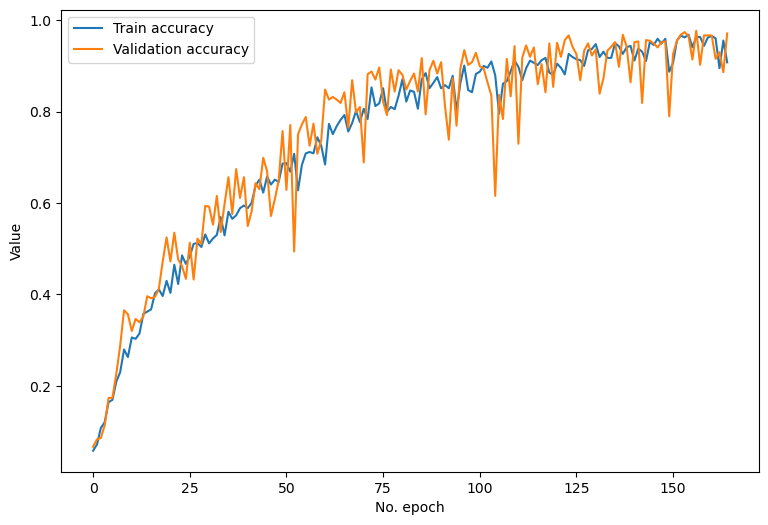

In [14]:
plt.figure(figsize=(9,6))
plt.plot(model_GRU.history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(model_GRU.history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

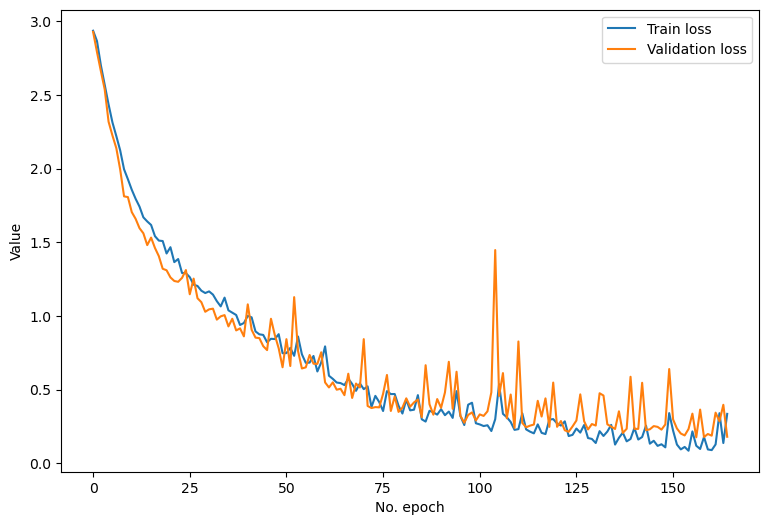

In [15]:
plt.figure(figsize=(9,6))
plt.plot(model_GRU.history.history['loss'], label='Train loss')
plt.plot(model_GRU.history.history['val_loss'], label='Validation loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [16]:
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 30, 64)            331776    
                                                                 
 dropout_8 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_7 (GRU)                 (None, 30, 128)           74496     
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [17]:
model_GRU.save('Model/GRU/with_Face/GRU_Model.h5')

In [8]:
model_GRU = load_model('Model/GRU/with_Face/GRU_Model.h5')

Test Accuracy Model

In [19]:
yhat = model_GRU.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

model_GRU.evaluate(X_train, y_train)
model_GRU.evaluate(X_test, y_test)

22/22 [==============================] - 1s 24ms/step - loss: 0.1796 - categorical_accuracy: 0.9708


[0.1796352118253708, 0.9707602262496948]

In [20]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[640,   0],
        [  3,  41]],

       [[641,   1],
        [  3,  39]],

       [[643,   3],
        [  0,  38]],

       [[639,   1],
        [  1,  43]],

       [[656,   0],
        [  0,  28]],

       [[644,   2],
        [  0,  38]],

       [[656,   3],
        [  2,  23]],

       [[647,   0],
        [  1,  36]],

       [[647,   0],
        [  7,  30]],

       [[649,   1],
        [  1,  33]],

       [[648,   0],
        [  0,  36]],

       [[658,   0],
        [  0,  26]],

       [[641,   1],
        [  0,  42]],

       [[641,   1],
        [  1,  41]],

       [[656,   0],
        [  0,  28]],

       [[645,   0],
        [  0,  39]],

       [[653,   0],
        [  0,  31]],

       [[638,   7],
        [  0,  39]],

       [[650,   0],
        [  1,  33]]], dtype=int64)

# Test Model in real time

In [12]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
confidence = 0.95

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FPS, 30)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model_GRU.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

        # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] >= confidence:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1:
                sentence = sentence[-1:]

        cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('Result', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
